# Goal 
- QA instrumentation for font size in Minerva skin on mobile web
- Collect baseline for font size in Minerva skin on mobile web 


Data QA Ticket: https://phabricator.wikimedia.org/T346978   
Baseline Analysis Ticket: https://phabricator.wikimedia.org/T346979

__Run on Nov. 08, 2023__

In [7]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)

# QA a non-default font size in the Minerva skin (On mobile web) 

In [31]:
query_mobile_daily <- "
SELECT TO_DATE(dt) AS event_date,  event.font, count(Distinct event.token) AS count_session, count(1) AS events
FROM event.MobileWebUIActionsTracking
WHERE year=2023 and month=11 
AND event.action='init'
GROUP BY TO_DATE(dt)  ,  event.font
ORDER BY event_date
LIMIT 10000
"

In [33]:
df_mobile_minerva_daily <- wmfdata::query_hive(query_mobile_daily)

Don't forget to authenticate with Kerberos using kinit



In [35]:
df_mobile_minerva_daily$event_date <- as.Date(df_mobile_minerva_daily$event_date )

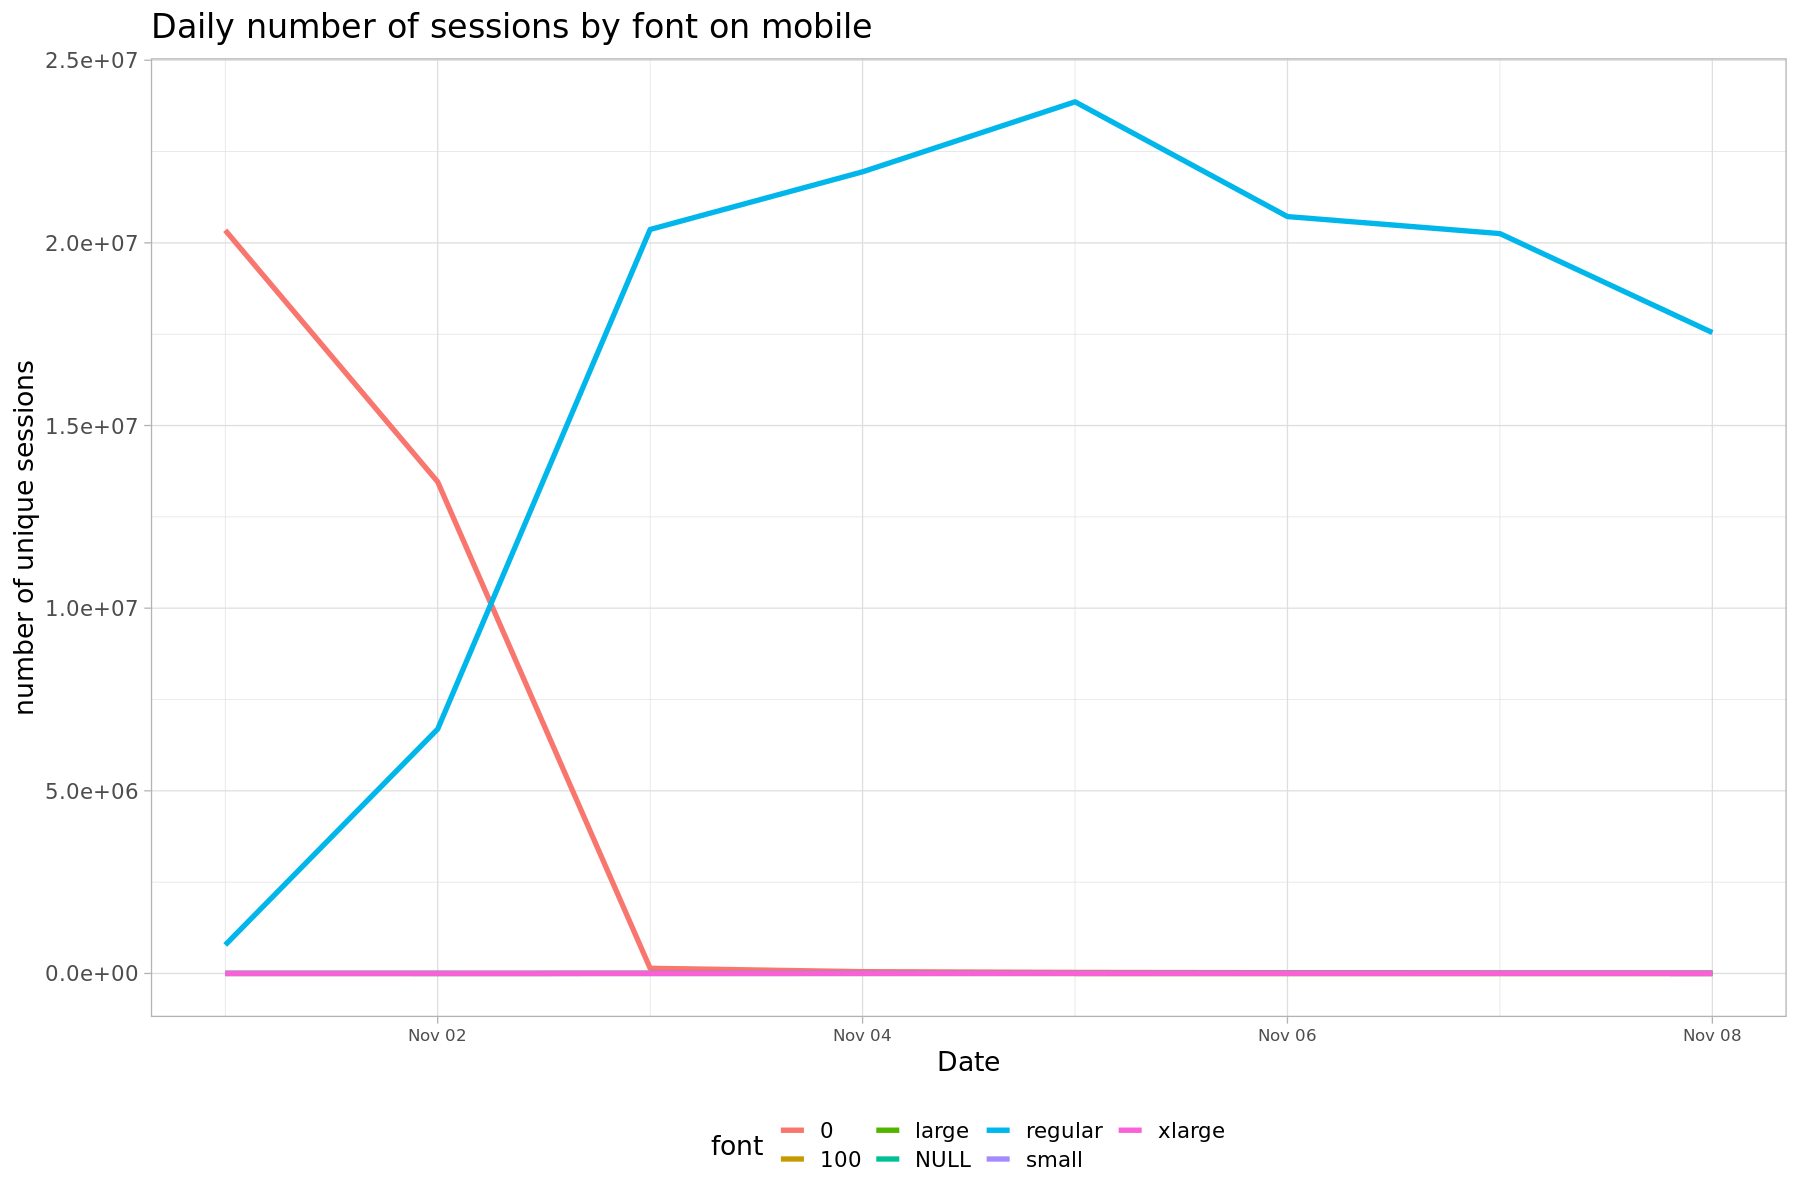

In [36]:
g_daily <- df_mobile_minerva_daily %>%
    ggplot(  mapping=aes(x=event_date, y= count_session, color=font)) +
geom_line( linewidth = 1.5) +
labs(title = 'Daily number of sessions by font on mobile',
     x = 'Date',
     y = 'number of unique sessions') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_daily

### Findings
The '0' events dropped since Nov 3. We can use the data after Nov 4 for baseline analysis.   
'0' and 'NULL' events should taper off eventually. They will be excluded from baseline analysis.

# Baseline analysis
% of pageviews which have set a non-default font size in the Minerva skin (On mobile web)


In [37]:
# No bot detected in the analysis period. So remove event.userGroups  regexp "bot" to speed up SQL. 
query_font_mobile_minerva <- "
-- MobileWebUIActionsTracking only capture the events from users in minerva skin
SELECT TO_DATE(dt) AS event_date, event.isAnon, event.font, count(Distinct event.token) AS count_session, count(1) AS events
FROM event.MobileWebUIActionsTracking
WHERE year=2023 and month=11 
AND event.action='init'
AND event.font IS NOT NULL 
AND event.font!='0'
GROUP BY TO_DATE(dt)  ,  event.isAnon, event.font
ORDER BY event.isAnon, event_date
LIMIT 10000
"

In [38]:
df_font_mobile_minerva <- wmfdata::query_hive(query_font_mobile_minerva)

Don't forget to authenticate with Kerberos using kinit



In [40]:
df_font_summary <- df_font_mobile_minerva %>%
  filter(event_date>'2023-11-03') %>%
  filter(font!='100') %>%
  select(event_date, isanon, font, count_session) %>%
  spread(key=font, value=count_session) %>%
  arrange(isanon)

In [42]:
df_font_summary <- df_font_summary %>%
  mutate(
   total_sessions=large+regular+small+xlarge,
   non_default_rate=round(1-regular/total_sessions, 8)
  )

In [44]:
df_font_summary %>% 
    group_by( isanon)%>%
        summarize(min=min(non_default_rate), max=max(non_default_rate), avg=mean(non_default_rate), std=sd(non_default_rate), .groups='drop')     

isanon min        max        avg         std         
1 false  0.01184367 0.01280090 0.012413984 4.350025e-04
2 true   0.00013925 0.00014659 0.000144288 2.974226e-06

### Finding
Preference by font size

- For logged-in users, most users with non-default font sizes opt for small.
- For anonymous users, most users with non-default font sizes opt for large and extra-large